### Boilerplate

In [1]:
import keras
import numpy
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn import preprocessing
import seaborn as sn

# To read CSV and XLS files.
import pandas # https://pandas.pydata.org/docs/user_guide/index.html

### Load Data and pre-process

In [2]:
# Import full dataset
fullData_CSV = pandas.read_csv('/content/drive/MyDrive/BIOPHYS 9709B/Final Project/12wp_NeuralMetrics_Full.csv')


# Remove half week and day measures
cleanData_CSV = fullData_CSV[(fullData_CSV['Week'] == 2) | (fullData_CSV['Week'] == 3) | (fullData_CSV['Week'] == 4) | (fullData_CSV['Week'] == 5) | (fullData_CSV['Week'] == 6) | (fullData_CSV['Week'] == 7)]
cleanData_CSV = cleanData_CSV.drop('Day',1)

# Remove features that aren't used
cleanData_CSV = cleanData_CSV.drop('Treatment_ID',1)
cleanData_CSV = cleanData_CSV.drop('Individual',1)
cleanData_CSV = cleanData_CSV.drop('Clone',1)
cleanData_CSV = cleanData_CSV.drop('Density',1)
cleanData_CSV = cleanData_CSV.drop('Condition',1)
cleanData_CSV = cleanData_CSV.drop('Number.of.Trials',1)
cleanData_CSV = cleanData_CSV.drop('Evoked.Spike.Count...Avg',1)
cleanData_CSV = cleanData_CSV.drop('Evoked.Spike.Count...Std',1)
cleanData_CSV = cleanData_CSV.drop('Evoked.Response.Probability',1)
cleanData_CSV = cleanData_CSV.drop('Evoked.First.Spike.Latency..ms.',1)
cleanData_CSV = cleanData_CSV.drop('Evoked.Jitter..ms.',1)

# Replace well label with an integer
cleanData_CSV = cleanData_CSV.replace(to_replace = "A1", value = 1)
cleanData_CSV = cleanData_CSV.replace(to_replace = "A2", value = 2)
cleanData_CSV = cleanData_CSV.replace(to_replace = "A3", value = 3)
cleanData_CSV = cleanData_CSV.replace(to_replace = "A4", value = 4)
cleanData_CSV = cleanData_CSV.replace(to_replace = "B1", value = 5)
cleanData_CSV = cleanData_CSV.replace(to_replace = "B2", value = 6)
cleanData_CSV = cleanData_CSV.replace(to_replace = "B3", value = 7)
cleanData_CSV = cleanData_CSV.replace(to_replace = "B4", value = 8)
cleanData_CSV = cleanData_CSV.replace(to_replace = "C1", value = 9)
cleanData_CSV = cleanData_CSV.replace(to_replace = "C2", value = 10)
cleanData_CSV = cleanData_CSV.replace(to_replace = "C3", value = 11)
cleanData_CSV = cleanData_CSV.replace(to_replace = "C4", value = 12)

# Replace nan values with -1
cleanData_CSV = cleanData_CSV.replace(to_replace = numpy.nan, value = -1)

# Extract Labels from Data
genotype_labels = cleanData_CSV['Genotype'].values
week_labels = cleanData_CSV['Week'].values

# Create stage labels (Early(1) = week 2-3; Middle(2) = week 4-5; Late(3) = week 6-7)
stage_labels = week_labels
stage_labels = numpy.where(stage_labels == 2, 1, stage_labels)
stage_labels = numpy.where(stage_labels == 3, 1, stage_labels)
stage_labels = numpy.where(stage_labels == 4, 2, stage_labels)
stage_labels = numpy.where(stage_labels == 5, 2, stage_labels)
stage_labels = numpy.where(stage_labels == 6, 3, stage_labels)
stage_labels = numpy.where(stage_labels == 7, 3, stage_labels)
week_labels = stage_labels

# Convert genotype labels into integers
genotype_labels = numpy.array(numpy.unique(genotype_labels, return_inverse=True)[1].tolist())

# Replace cleanData genotype string with integer
cleanData_CSV['Genotype'] = genotype_labels

# Create a forth label with genotype and week/ stage combined. This will allow both genotype and timepoint to be classified
genotype_week_labels = (genotype_labels * (numpy.size(numpy.unique(week_labels)))) + week_labels-1
labels = genotype_week_labels

# Remove genotype and week labels from cleanData_CSV and create input vectors
x = cleanData_CSV.drop('Genotype', 1) #1 is axis number. 0 for row, 1 for column
x = cleanData_CSV.drop('Week',1)

# Standardize input
sc = StandardScaler()
x = sc.fit_transform(x)

# One hot encoder
ohe = OneHotEncoder()
labels = numpy.reshape(labels,(-1,1))
y = ohe.fit_transform(labels).toarray() # Create output one hot vector for each label

# Create train and test split
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.25)

### Defining hyper-parameters




In [3]:
my_learning_rate = 0.025 # Learning Rate
my_batch_size = 15 # Batch Size
my_epochs = 1000 # Number of Epochs
num_classes = numpy.size(numpy.unique(labels)) # Number of classes varies depending on the number of unique labels (dependent on the problem i.e. classifying RTT vs WT or time point or both)
my_patience = 40 # Number of epochs where we don't see improvement before early stopping

# Pick loss function and output activation function depending on the number of classes (2 for genotype ONLY, 6 for weeks ONLY, 12 for genotype and weeks, 6 for genotype and weeks)
if num_classes > 2:
  loss_function = keras.losses.categorical_crossentropy
  output_activation_function = 'softmax'
else:
  loss_function = keras.losses.binary_crossentropy
  output_activation_function = 'sigmoid'


### Defining the Network

In [4]:
def rtt_model():
  feature_shape = (x_train.shape[1]) # Input size of feature vector  
  input_layer = keras.layers.Input(feature_shape) # Input layer
  layer_0 = keras.layers.Dense(32, activation = 'relu')(input_layer) # First hidden layer with 32 neurons and ReLU activation function
  dropout_layer_0 = keras.layers.Dropout(0.25)(layer_0) # Dropout connection with probability of 0.25
  layer_1 = keras.layers.Dense(64, activation = 'relu')(dropout_layer_0) # Second hidden layer with 64 neurons and ReLU activation function
  dropout_layer_1 = keras.layers.Dropout(0.6)(layer_1) # Dropout connection with probability of 0.6
  layer_2 = keras.layers.Dense(32, activation = 'relu')(dropout_layer_1) # Third hidden layer with 32 neurons and ReLU activation function
  dropout_layer_2 = keras.layers.Dropout(0.5)(layer_2) # Dropout connection with probability of 0.5
  layer_3 = keras.layers.Dense(18, activation = 'relu')(dropout_layer_2) # Final hidden layer with 18 neurons and ReLU activation function
  output_layer = keras.layers.Dense(num_classes,activation = output_activation_function)(layer_3) # Output layer with appropriate activation function dependent on number of classes
  model = keras.models.Model(inputs = input_layer, outputs = output_layer) # Create model

  return model

# Create model by calling rtt_model
model = rtt_model()

# Appropriate loss function dependent on number of classes and Stochastic gradient descent optimizer with a learning rate of my_learning_rate, while keeping track of accuracy
model.compile(loss = loss_function, optimizer = keras.optimizers.SGD(learning_rate = my_learning_rate), metrics = 'accuracy')

# Create summary of model
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 53)]              0         
_________________________________________________________________
dense (Dense)                (None, 32)                1728      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                2112      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0     

In [5]:
# Early Stopping function with a patience of my_patience defined in hyperparameters section
my_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=my_patience)

### Training

In [6]:
history = model.fit(x_train, y_train, batch_size = my_batch_size, epochs = my_epochs, validation_split = 0.1, callbacks = my_callback)

Epoch 1/1000
23/23 [==============================] - 1s 22ms/step - loss: 1.9229 - accuracy: 0.2247 - val_loss: 1.7623 - val_accuracy: 0.2632
Epoch 2/1000
23/23 [==============================] - 0s 4ms/step - loss: 1.8199 - accuracy: 0.2065 - val_loss: 1.7230 - val_accuracy: 0.2368
Epoch 3/1000
23/23 [==============================] - 0s 4ms/step - loss: 1.7567 - accuracy: 0.2228 - val_loss: 1.7036 - val_accuracy: 0.2632
Epoch 4/1000
23/23 [==============================] - 0s 5ms/step - loss: 1.6487 - accuracy: 0.2863 - val_loss: 1.6756 - val_accuracy: 0.2105
Epoch 5/1000
23/23 [==============================] - 0s 4ms/step - loss: 1.6968 - accuracy: 0.2185 - val_loss: 1.6452 - val_accuracy: 0.2632
Epoch 6/1000
23/23 [==============================] - 0s 4ms/step - loss: 1.6090 - accuracy: 0.3224 - val_loss: 1.6112 - val_accuracy: 0.2632
Epoch 7/1000
23/23 [==============================] - 0s 4ms/step - loss: 1.5494 - accuracy: 0.3045 - val_loss: 1.5758 - val_accuracy: 0.3684
Epoch

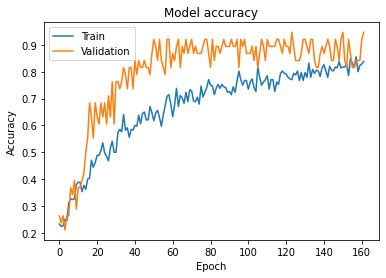

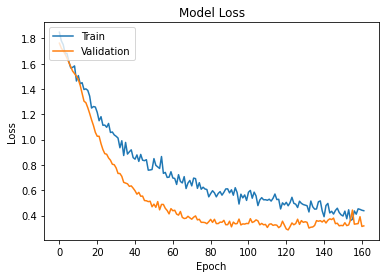

In [7]:
# Plot training and validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.show()

# Plot training and validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.show()

### Inference and Output

Precision:  [[0.84210526]
 [0.7826087 ]
 [0.94444444]
 [0.95652174]
 [0.8       ]
 [0.82608696]]
Recall:  [[0.88888889]
 [0.81818182]
 [0.85      ]
 [0.95652174]
 [0.76190476]
 [0.86363636]]
F1 Score:  [[0.86486486]
 [0.8       ]
 [0.89473684]
 [0.95652174]
 [0.7804878 ]
 [0.84444444]]


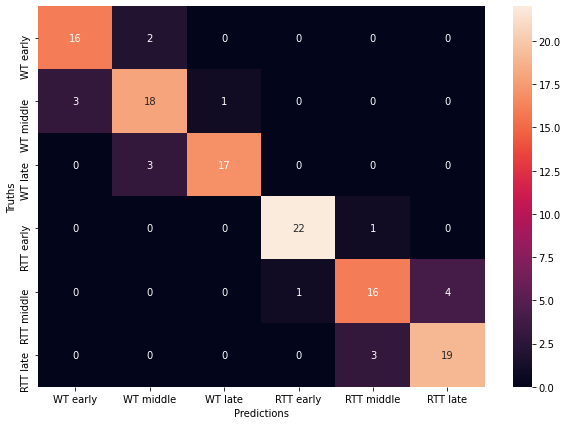

In [8]:
# Inference
results = model.predict(x_test, batch_size = my_batch_size)

# Get prediction and truth labels
predictions = numpy.argmax(results, axis = 1)
truths = numpy.argmax(y_test, axis = 1)

# Create text labels for confusion matrix
label_names = ['WT early', 'WT middle', 'WT late', 'RTT early', 'RTT middle', 'RTT late']

def ErrorMetrics (predictions, truths):

  confusion_matrix = sklearn.metrics.confusion_matrix(truths, predictions); # Generate confusion matrix from truths and predictions

  # Create heatmap for confusion matrix
  df_cm = pandas.DataFrame(confusion_matrix, index = [i for i in label_names], columns = [i for i in label_names]) # Create dataframe with confusion matrix and labels
  plt.figure(figsize = (10,7)) # Control figure size
  sn.heatmap(df_cm, annot = True) # Output heatmap
  # Label axes
  plt.xlabel('Predictions')
  plt.ylabel('Truths')

  # Create empty vector to store our error metrics
  F1_score = numpy.empty((num_classes,1))
  recall = numpy.empty((num_classes,1))
  precision = numpy.empty((num_classes,1)) 

  # Iterate through each class and calculate F1 score
  for i in range (num_classes):
    TP = confusion_matrix[i][i] # Calculate true positives
    FN = sum(confusion_matrix[i][:]) - TP # Calculate false negatives
    FP = sum([row[i] for row in confusion_matrix]) - TP # Calculate false positive
    precision[i] = TP / (TP + FP) # Calculate precision
    recall[i] = TP / (TP + FN) # Calculate recall
    F1_score[i] = 2 * (precision[i] * recall[i])/(precision[i] + recall[i]) # Calculate F1
  
  return precision, recall, F1_score # Return error metrics

# Call error metrics function and output metric
precision, recall, F1_score = ErrorMetrics(predictions, truths)
print("Precision: " , precision)
print("Recall: ", recall)
print("F1 Score: ", F1_score)